# Imports

In [90]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import fitz as fitz
import re as re
from enum import Enum
import io as io

## Classes and Enums

In [91]:
# using as a value tracker

class RoomOrder(Enum):
	ABF = 0 # 18a, 18b, 18
	BAF = 1 # 18b, 18a, 18
	AFB = 2 # 18a, 18, 18b
	BFA = 3 # 18b, 18, 18a
	FAB = 4 # 18, 18a, 18b
	FBA = 5 # 18, 18b, 18a
	BA = 6 # 18b, 18a
	BF = 7 # 18b, 18
	FB = 8 # 18, 18b
	FA = 9 # 18, 18a
	AB = 10 # 18a, 18b
	AF = 11 # 18a, 18
	A = 12 # 18a
	B = 13 # 18b
	F = 14 # 18

class GroupComp(Enum):
	INDIVIDUAL = 0
	GROUP = 1

class LecternsViewed(Enum):
	N = "None"
	W = "West"
	M = "Middle"
	E = "East"
	WM = "West, Middle"
	WE = "West, East"
	ME = "Middle, East"
	WME = "West, Middle, East"

class VisitorType(Enum):
	BROWSER = 0
	FOLLOWER = 1
	SEARCHER = 2
	RESEARCHER = 3

class TurnDirection(Enum):
	LEFT = 0
	MIDDLE = 1
	RIGHT = 2
	NONE = 3

class TeamMember(Enum):
	Courtney = 0
	Jerry = 1
	Owen = 2
	Ritvik = 3
	Sofia = 4

class Gender(Enum):
	FEMALE = 0
	MALE = 1

class FirstTurnDirection(Enum):
	LEFT = 0
	MIDDLE = 1
	RIGHT = 2

class DayOfWeek(Enum):
	Sunday = 0
	Monday = 1
	Tuesday = 2
	Wednesday = 3
	Thursday = 4
	Friday = 5
	Saturday = 6

# Code

## Constants

In [92]:
# relative file paths
visitor_xlsx_path: str = "../../assets/excel_files/observation_tables.xlsx"
survey_xlsx_path: str = "../../assets/excel_files/survey_responses.xlsx"

# sheet names
main_sheet_name: str = "main data"
groups_sheet_name_base: str = "object group"

# export paths
observation_export_path: str = "../../assets/output_files/visitor_box_plots.pdf"
observation_metadata_export_path: str = "../../assets/metadata_output/visitor_box_plots_metadata.pdf"
slip_room_metadata_export_path: str = "../../assets/metadata_output/slip_room_box_plots_metadata.pdf"
group_export_path: str = "../../assets/output_files/group_box_plots.pdf"
group_metadata_export_path: str = "../../assets/metadata_output/group_box_plots_metadata.pdf"
survey_export_path: str = "../../assets/output_files/survey_box_plots.pdf"
survey_metadata_export_path: str = "../../assets/metadata_output/survey_box_plots_metadata.pdf"

## Loading XLSX

In [93]:
visitor_xlsx: pd.ExcelFile = pd.ExcelFile(visitor_xlsx_path)
visitor_df: pd.DataFrame = pd.read_excel(visitor_xlsx, sheet_name=main_sheet_name, index_col=0)

def get_full_room_time(series: pd.Series) -> float:
	return (series["total_time"] * 60 - series["18a_total_time"] - series["18b_total_time"]) / 60.0
	
visitor_df["18_total_time"] = visitor_df.apply(get_full_room_time, axis=1)

groups_df: pd.DataFrame = pd.DataFrame()
for i in visitor_df["visitor_id"].values:
	sheet_name: str = groups_sheet_name_base + " " + "{0:0=3d}".format(i)
	temp_df: pd.DataFrame = pd.read_excel(visitor_xlsx, sheet_name=sheet_name, index_col=0)
	col_name: str = "{0:0=3d}".format(i) + "_" + "dwell_time"
	groups_df[col_name] = temp_df["dwell_time"]
groups_df = groups_df.T

survey_xlsx: pd.ExcelFile = pd.ExcelFile(survey_xlsx_path)
survey_df: pd.DataFrame = pd.read_excel(survey_xlsx, index_col=8)
# isolate row of question names
survey_question_names: pd.Series = survey_df.iloc[0]
# remove row of question names
survey_df = survey_df[1:]

C:\Users\ritvi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openpyxl\styles\stylesheet.py:241: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [94]:
# formatting question names and extracting field names
regex: re.Pattern = re.compile(r"^(.+?): - ([^:]+):(.+)$")
survey_question_data: dict[str, tuple[str, str, str]] = {}

for i in survey_question_names.keys():
	match = regex.match(survey_question_names[i])
	if match:
		survey_question_data[i] = (match.group(1), match.group(2), match.group(3))

observation_titles: list = [
	"Time Spent in Room 18, 18a and 18b",
	"Time Spent in Room 18"
]

slip_room_titles: list = [
	"Room 18a",
	"Room 18b"
]

group_titles: list = [
	"South Metopes II-V",
	"West Pediments",
	"South Metopes VI-IX",
	"South Metopes XXVI-XXIX",
	"East Pediments",
	"South Metopes XXX-XXXII",
	"Frieze Section 1",
	"Frieze Section 2",
	"Frieze Section 3",
	"Frieze Section 4",
	"Frieze Section 5"
]

## Operations

### Support Functions

In [95]:
# lists of columns to analyze and snums to transform labels
OBSERVATION_ANALYSIS_COLS: list[str] = [
	"total_time",
	"18_total_time"
]

SLIP_ROOM_ANALYSIS_COLS: list[str] = [
	"18a_total_time",
	"18b_total_time"
]

OBSERVATION_ENUM_CLASSES: list[Enum] = []

GROUP_ANALYSIS_COLS: list[str] = [
	"South Metopes II-V",
	"West Pediments",
	"South Metopes VI-IX",
	"South Metopes XXVI-XXIX",
	"East Pediments",
	"South Metopes XXX-XXXII",
	"Frieze Section 1",
	"Frieze Section 2",
	"Frieze Section 3",
	"Frieze Section 4",
	"Frieze Section 5"
]

SURVEY_ANALYSIS_COLS_21: list[str] = [
	"Q21_1",
	"Q21_2",
	"Q21_3",
	"Q21_4",
	"Q21_5",
]
SURVEY_ANALYSIS_COLS_22: list[str] = [
	"Q22_1",
]
SURVEY_ANALYSIS_COLS_23: list[str] = [
	"Q23_1"
]

In [96]:
def plot_data(df: pd.DataFrame, analysis_cols: list, enum_classes: list, names: dict, titles: list, label: str, export_path: str, metadata_export_path: str, show_plots: bool) -> None:
	"""
	Generates boxplots for specified columns and saves them to a PDF.

	Creates horizontal boxplots for numerical data, excluding zero values and 
	NaNs. Plots are arranged two per page (top and bottom) in the resulting
	PDF document.

	Args:
		df: The pandas DataFrame containing the data to analyze.
		analysis_cols: List of column names to generate plots for.
		enum_classes: List of Enum classes (unused in this function version, 
					  kept for signature compatibility).
		names: A dictionary mapping column names to lists containing title 
			   components [line1, line2, subtitle].
		label: The label for the x-axis (e.g., unit of measurement).
		export_path: File path where the resulting PDF will be saved.
		show_plots: If True, displays each plot in the current environment.
	"""
	if names is None and len(analysis_cols) != len(titles):
		raise Exception("Analysis Columns and Titles do not have the same length.")
	elif names is None and titles is None:
		raise Exception("Required: names dictionary or titles list.")

	doc: fitz.Document = fitz.open()

	given_names: bool = names is not None

	page_width: int = 595
	page_height: int = 842

	margin: int = 50
	midpoint: int = page_height / 2

	master_map: dict[str, str] = {}
	for enum_cls in enum_classes:
		for member in enum_cls:
			master_map[member.name] = str(member.value)

	plot_df: pd.DataFrame = df.copy()

	metadata_text: str = ""

	for i, col in enumerate(analysis_cols):
		if i % 2 == 0:
			page: fitz.Page = doc.new_page(width=page_width, height=page_height)
		
		fig: plt.Figure
		ax: plt.Axes
		fig, ax = plt.subplots(figsize=(8, 5))

		df[col] = pd.to_numeric(df[col], errors='coerce')
		cleaned_data = df[(df[col] != 0) & (df[col].notna())][col]
		plt.boxplot(cleaned_data, vert=False)

		if given_names:
			plt.title(names[col][0] + "\n" + names[col][1] + " --- " + names[col][2])
		else:
			plt.title(titles[i])
		
		summary = cleaned_data.describe(percentiles=[.25, .5, .75])
		q1 = round(summary['25%'], 3)
		q3 = round(summary['75%'], 3)
		iqr = q3 - q1
		metadata_text += col + ":\n"
		metadata_text += "Min: " + str(round(summary['min'], 3)) + ", Q1: " + str(q1) + ", Median: " + str(round(summary['50%'], 3)) + ", Q3: " + str(q3) + ", Max: " + str(round(summary['max'], 3)) + ", IQR: " + str(iqr) + ", Mean: " + str(round(summary['mean'], 3)) + "\n\n"

		plt.xticks(rotation=45)
		plt.xlabel(label)
		plt.yticks([])
		plt.subplots_adjust(bottom=0.2, top=0.9)
		image_data: io.BytesIO = io.BytesIO()
		fig.savefig(image_data, format="png", dpi=150)
		if show_plots:
			plt.show(fig)
		image_data.seek(0)

		image_rect: fitz.Rect
		text_y: int
		if i % 2 == 0:
			image_rect = fitz.Rect(margin, margin, page_width - margin, midpoint - 40)
			text_y = midpoint - 20
		else:
			image_rect = fitz.Rect(margin, midpoint + 20, page_width - margin, page_height - margin - 40)
			text_y = page_height - 30
		
		page.insert_image(image_rect, stream=image_data.read())

		page.insert_text((margin, text_y), "Analysis for column '" + col + "'", fontsize=12)
		plt.close(fig)
	doc.save(export_path)
	doc.close()

	metadata_doc: fitz.Document = fitz.open()
	metadata_page: fitz.Page = metadata_doc.new_page()
	metadata_page.insert_text(
		fitz.Point(50, 50),
		metadata_text,
		fontsize=12
	)
	metadata_doc.save(metadata_export_path)
	metadata_doc.close()

### Execution

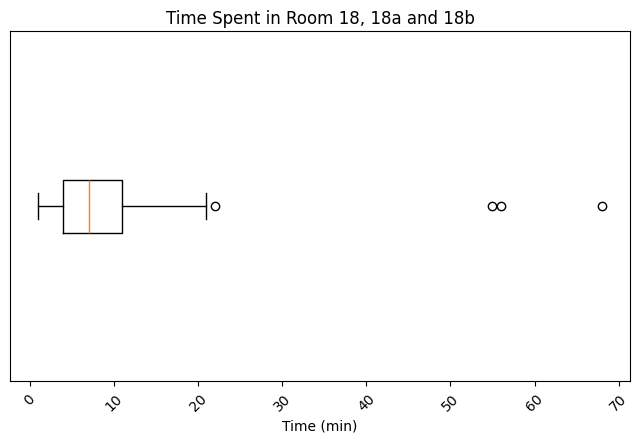

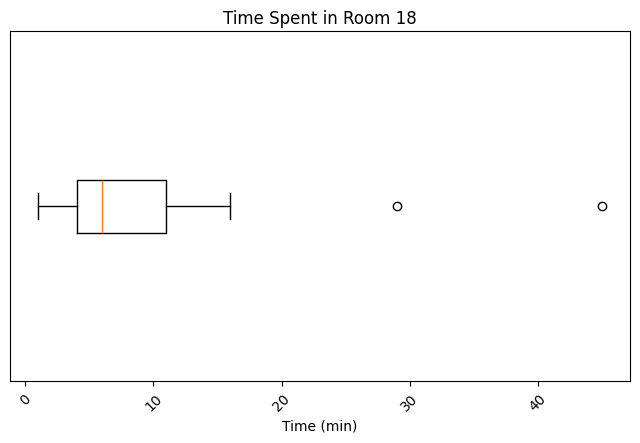

In [97]:
plot_data(visitor_df, OBSERVATION_ANALYSIS_COLS, OBSERVATION_ENUM_CLASSES, None, observation_titles, "Time (min)", observation_export_path, observation_metadata_export_path, True)

In [98]:
def plot_group_data(df: pd.DataFrame, analysis_cols: list, names: dict, titles: list, label: str, plot_title: str, export_path: str, metadata_export_path: str, show_plots: bool, create_new_doc: bool) -> None:
	doc: fitz.Document = (fitz.open() if create_new_doc else fitz.open(export_path))
	page: fitz.Page = doc.new_page()

	given_names: bool = names is not None

	page_width: int = 595
	page_height: int = 842

	margin: int = 50
	midpoint: int = page_height / 2
	
	plot_df: pd.DataFrame = df.copy()

	fig: plt.Figure
	ax: plt.Axes
	fig, ax = plt.subplots(figsize=(8, 5))
	metadata_text: str = ""

	plot_data: list = []
	plot_labels: list = []

	for i, col in enumerate(analysis_cols):

		df[col] = pd.to_numeric(df[col], errors='coerce')
		cleaned_data = df[(df[col] != 0) & (df[col].notna())][col]
		plot_data.append(cleaned_data)

		if given_names:
			plot_labels.append(names[col][1] + " to " + names[col][2])
		else:
			plot_labels.append(titles[i])

		summary = cleaned_data.describe(percentiles=[.25, .5, .75])
		q1 = round(summary['25%'], 3)
		q3 = round(summary['75%'], 3)
		iqr = q3 - q1
		metadata_text += col + ":\n"
		metadata_text += "Min: " + str(round(summary['min'], 3)) + ", Q1: " + str(q1) + ", Median: " + str(round(summary['50%'], 3)) + ", Q3: " + str(q3) + ", Max: " + str(round(summary['max'], 3)) + ", IQR: " + str(iqr) + ", Mean: " + str(round(summary['mean'], 3)) + "\n\n"

	ax.boxplot(plot_data, vert=False, tick_labels=plot_labels)
	
	plt.xticks(rotation=45)
	plt.xlabel(label)
	if plot_title is None:
		ax.set_title(names[col][0])
	else:
		ax.set_title(plot_title)

	plt.tight_layout()
	# plt.subplots_adjust(bottom=0.2, top=0.9)
	image_data: io.BytesIO = io.BytesIO()
	fig.savefig(image_data, format="png", dpi=150)
	if show_plots:
		plt.show(fig)
	image_data.seek(0)

	image_rect: fitz.Rect
	text_y: int
	image_rect = fitz.Rect(margin, margin, page_width - margin, midpoint - 40)
	text_y = midpoint - 20
	page.insert_image(image_rect, stream=image_data.read())

	plt.close(fig)
	if create_new_doc:
		doc.save(export_path)
	else:
		doc.saveIncr()
	doc.close()

	metadata_doc: fitz.Document = fitz.open()
	metadata_page: fitz.Page = metadata_doc.new_page()
	metadata_page.insert_text(
		fitz.Point(50, 50),
		metadata_text,
		fontsize=12
	)
	metadata_doc.save(metadata_export_path)
	metadata_doc.close()

In [99]:
plot_group_data(groups_df, GROUP_ANALYSIS_COLS, None, group_titles, "Time (sec)", "Time Spent at Artifact Sections", group_export_path, group_metadata_export_path, False, True)

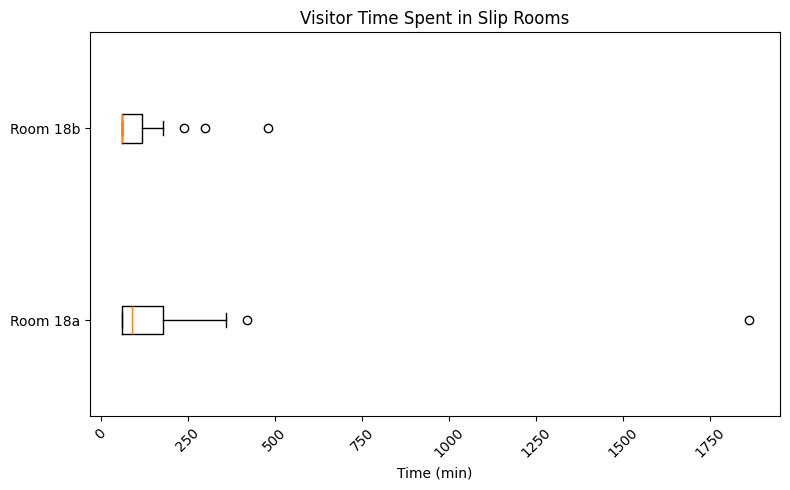

In [100]:
plot_group_data(visitor_df, SLIP_ROOM_ANALYSIS_COLS, None, slip_room_titles, "Time (min)", "Visitor Time Spent in Slip Rooms", observation_export_path, slip_room_metadata_export_path, True, False)

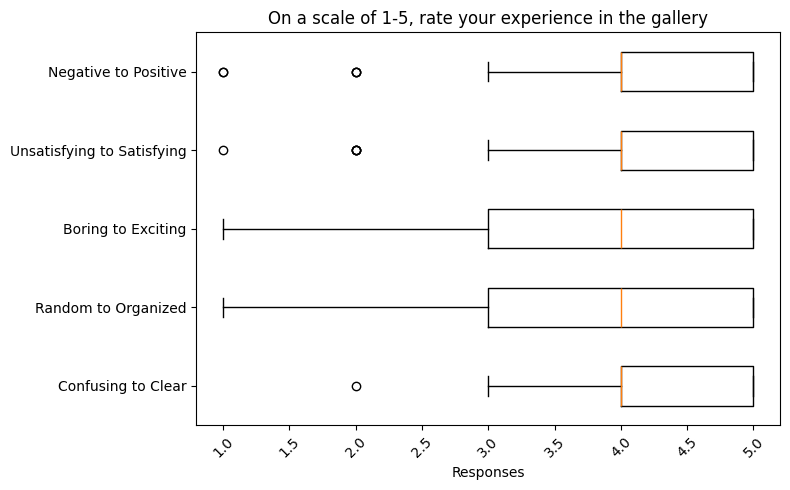

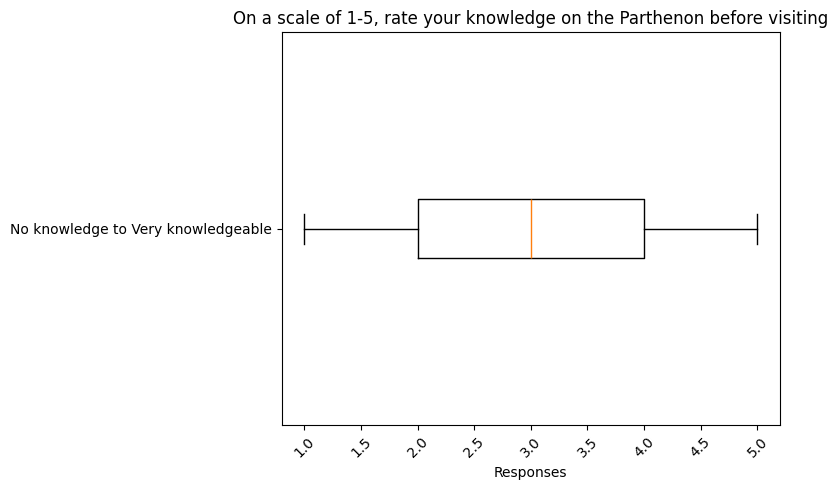

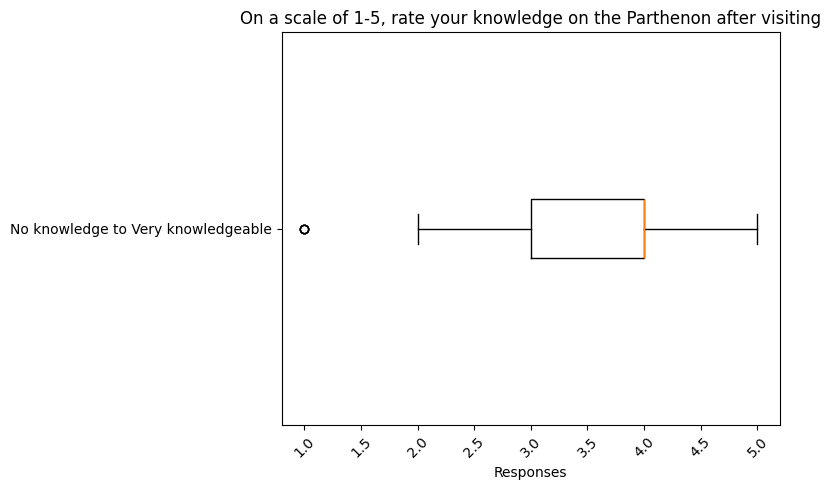

In [101]:
plot_group_data(survey_df, SURVEY_ANALYSIS_COLS_21, survey_question_data, None, "Responses", None, survey_export_path, survey_metadata_export_path, True, True)
plot_group_data(survey_df, SURVEY_ANALYSIS_COLS_22, survey_question_data, None, "Responses", None, survey_export_path, survey_metadata_export_path, True, False)
plot_group_data(survey_df, SURVEY_ANALYSIS_COLS_23, survey_question_data, None, "Responses", None, survey_export_path, survey_metadata_export_path, True, False)